In [1]:
from pymongo import MongoClient
import csv
import time
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics

In [2]:
myclient = MongoClient("mongodb://localhost:27017/")
db = myclient.ProjectIF29
collection = db['Tweets']

### Chercher le nombre d'utilisateur dans la base

In [3]:
Nombre_utilisateur = []
for user in collection.aggregate([
    {
        "$group": {"_id": "$user.id"}
    }]):
    Nombre_utilisateur.append(user)
len(Nombre_utilisateur)

1843439

### Generer les attributs du graphe social 

- **_id**: id du user
- **friends_count** : nombre de profils suivis
- **followers_count**: nombre de followers ou d'abonnees
- **listed_count**: le nombre de mention publique pour cet utilisateur
- **statuses_count**: le nombre de tweet et retweet emis par le user
- **favourites_count**: nombre de favoris ou nombre de tweets likés depuis la creation du compte 
- **accounted_created_time**: jour et heure de la creation du compte
- **tweet_created_time** : jour et heure de la creation du tweet
- **Age du profil**: du premier tweet au dernier tweet
- **agressivite**
- **visibilite**
- **nombre d'url**
- **longueur moyen des tweets**
- **nombre de reponses**
- **retweet_count**: Nombre de fois que ce tweet a ete retweete
- **reply_count**: Nombre de fois que ce tweet a ete repondu
- **favorite_count**: Nombre de fois que ce tweet a ete like
- **frequencetweet**
- **longueumoyen**

La plupart de ces attributs seront generes par rapport a l'univers. Pour ce faire nous avons besoin des attributs a l'entree et a la sortie de l'univers, pour pouvoir faire une variation et calculer les attributs dans l'univers.\
Nous calculons donc les valeurs minales et valeurs maximales.

In [ ]:
collection.create_index([("user.id", 1)])

In [ ]:
from bson.code import Code
debut = time.time()
#-------fonction pour calculer la longueur moyen d'un tweet---------------

longtweet = Code('''
function(tweets) {
        return tweets.length;}
''')

#------------fonction pour calculer le nombre moyen de hshtag et de reference
hsref = Code('''
function(tweets) {
        var total = 0;
        total += tweets.split('#').length - 1;
        return total;
}''')

ref = Code('''
function(tweets) {
        var total = 0;
        total += tweets.split('@').length - 1;
        return total;
}''')
#--------nombre url------- 
NombreUrl = Code('''function (text) {
  // Expression régulière pour trouver les URL
  var urlRegex = /https?:\/\/[^\s/$.?#].[^\s]*/gi;
  
  // Trouver toutes les correspondances avec la regex
  var matches = text.match(urlRegex);
  
  // Renvoyer le nombre total d'URL trouvées
  return matches ? matches.length : 0;
}
''')
#
dateMin = Code('''
function(created_at){
        var total = Date.parse("Sun May 15 12:34:56 +0000 2023");
        for (var doc of created_at) {
            total = Math.min(total, Date.parse(doc));
        };
        return total;}
''')
#Fonction pour caluculer les dates
date = Code('''
function(created_at){
        return  Date.parse(created_at);}
''')    
  
age = collection.aggregate([
    {
        '$group': {
            '_id': '$user.id',
            'userCreateDate':{'$first': '$user.created_at'},
            'Maxfollowers': {'$max': '$user.followers_count'},
            'Minfollowers': {'$min': '$user.followers_count'},
            'retweet':{'$sum': '$retweet_count'},
            'reply':{'$sum':'$reply_count'},
            'MaxAmi':{'$max':'$user.friends_count'},
            'MinAmi':{'$min': '$user.friends_count'},
            'MaxStatuses':{'$max':'$user.statuses_count'},
            'MinStatuses':{'$min':'$user.statuses_count'},
            'Maxfavourites':{'$max':'$user.favourites_count'},
            'Minfavourites':{'$min':'$user.favourites_count'},
            'Maxmention': {'$max':'$user.listed_count'},
            'Minmention':{'$min':'$user.listed_count'},
            'tweets':{'$push': '$text'},
             'nombre_tweet':{'$count':{}},
            'longTotalTweet':{'$sum':{'$function':{'body':longtweet, 'args':['$text'],'lang':'js'}}},
            'hstag':{'$sum':{'$function':{'body':hsref, 'args':['$text'], 'lang':'js'}}},
            'reference':{'$sum':{'$function':{'body':ref, 'args':['$text'], 'lang':'js'}}},
            'Nombreurl':{'$sum':{'$function':{'body': NombreUrl, 'args':['$text'], 'lang':'js'}}},
            'dateMax':{'$max':{'$function':{'body': date, 'args':['$created_at'], 'lang':'js'}}},
            'dateMin':{'$min':{'$function':{'body': date, 'args':['$created_at'], 'lang':'js'}}},
            'DateUser':{'$min':{'$function':{'body': date, 'args':['$user.created_at'], 'lang':'js'}}}
        }
    }
])
        
entetes=['_id', 'userCreateDate', 'Maxfollowers', 'Minfollowers', 'retweet', 'reply','MaxAmi','MinAmi','MaxStatuses','MinStatuses','Maxfavourites','Minfavourites'
        ,'Maxmention','Minmention', 'nombre_tweet', 'tweets','longTotalTweet', 'hstag', 'reference','Nombreurl', 'dateMax', 'dateMin','DateUser']
with open('User.csv', 'w', newline='', encoding ='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=entetes)
    writer.writeheader()
    writer.writerows(age)
print('---------------------------Temps execution')
print(time.time()-debut)

### Explorer les donnees user

In [3]:
df = pd.read_csv('User.csv')
##----------Affichons les 5 premiers elements--------
df.head(5)

,_id,userCreateDate,Maxfollowers,Minfollowers,retweet,reply,MaxAmi,MinAmi,MaxStatuses,MinStatuses,...,Minmention,nombre_tweet,tweets,longTotalTweet,hstag,reference,Nombreurl,dateMax,dateMin,DateUser
0,418,Wed Jul 05 19:52:46 +0000 2006,87904,87890,0,0,2489,2486,66656,66601,...,4535,6,['Re: 4SQ. You can search for “world cup” or ...,680.0,6.0,4.0,5.0,1.529240e+12,1.529060e+12,1.152129e+12
1,730,Fri Jul 14 01:15:50 +0000 2006,621,621,0,0,191,191,12159,12159,...,20,1,"[""RT @Kasparov63: As I've written, it is up to...",139.0,0.0,1.0,0.0,1.529000e+12,1.529000e+12,1.152840e+12
2,761,Fri Jul 14 04:56:28 +0000 2006,4562,4562,0,0,483,483,29724,29724,...,188,1,['Co-sign https://t.co/3fJRCqqaBl'],31.0,0.0,0.0,1.0,1.529097e+12,1.529097e+12,1.152853e+12
3,885,Fri Jul 14 15:12:42 +0000 2006,21491,21491,0,0,1099,1099,13879,13879,...,1883,1,"['If you tape a #WorldCup game to work, that a...",88.0,1.0,0.0,0.0,1.529103e+12,1.529103e+12,1.152890e+12
4,922,Fri Jul 14 17:59:15 +0000 2006,4399,4399,0,0,934,934,11717,11717,...,268,1,['If you’re in SF tomorrow swing by our #GER\u...,140.0,3.0,1.0,1.0,1.529201e+12,1.529201e+12,1.152900e+12


In [4]:
### description de la donnees user
df.describe()

,_id,Maxfollowers,Minfollowers,retweet,reply,MaxAmi,MinAmi,MaxStatuses,MinStatuses,Maxfavourites,...,Maxmention,Minmention,nombre_tweet,longTotalTweet,hstag,reference,Nombreurl,dateMax,dateMin,DateUser
count,1.843439e+06,1.843439e+06,1.843439e+06,1843439.0,1843439.0,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,...,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06
mean,2.276477e+17,3.602963e+03,3.598628e+03,0.0,0.0,8.718743e+02,8.680995e+02,1.768635e+04,1.766600e+04,8.762232e+03,...,2.446212e+01,2.420749e+01,2.479062e+00,2.717432e+02,4.257291e+00,2.157173e+00,1.384654e+00,1.529117e+12,1.529078e+12,1.379295e+12
std,3.886710e+17,1.185683e+05,1.185233e+05,0.0,0.0,4.897467e+03,4.870705e+03,4.049905e+04,4.046705e+04,2.204889e+04,...,3.980214e+02,3.950843e+02,9.279491e+00,1.079546e+03,2.520273e+01,9.943661e+00,6.660470e+00,8.939842e+07,8.615555e+07,8.972072e+10
min,4.180000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.528942e+12,1.528942e+12,0.000000e+00
25%,3.033891e+08,1.040000e+02,1.030000e+02,0.0,0.0,1.680000e+02,1.670000e+02,1.108000e+03,1.101000e+03,4.450000e+02,...,0.000000e+00,0.000000e+00,1.000000e+00,9.700000e+01,1.000000e+00,1.000000e+00,0.000000e+00,1.529044e+12,1.528996e+12,1.306094e+12
50%,1.460774e+09,2.980000e+02,2.970000e+02,0.0,0.0,3.580000e+02,3.560000e+02,5.210000e+03,5.199000e+03,2.168000e+03,...,2.000000e+00,2.000000e+00,1.000000e+00,1.400000e+02,2.000000e+00,1.000000e+00,1.000000e+00,1.529118e+12,1.529076e+12,1.370012e+12
75%,7.125350e+17,7.540000e+02,7.520000e+02,0.0,0.0,7.590000e+02,7.570000e+02,1.789600e+04,1.787400e+04,7.931000e+03,...,9.000000e+00,8.000000e+00,2.000000e+00,2.330000e+02,4.000000e+00,2.000000e+00,1.000000e+00,1.529183e+12,1.529151e+12,1.458717e+12
max,1.008393e+18,4.220341e+07,4.219805e+07,0.0,0.0,1.569366e+06,1.569366e+06,8.910230e+06,8.898257e+06,1.718515e+06,...,1.953890e+05,1.952950e+05,7.143000e+03,7.606790e+05,2.199300e+04,9.153000e+03,3.310000e+03,1.529255e+12,1.529255e+12,1.529255e+12


### suppression de reply et de retweet
On constate que les colonnes retweet et reply ont tous que des valeurs nulles. Nous allons donc les supprimer.

In [5]:
df.drop(df.columns[[4,5]], inplace = True, axis=1)
df.head(4)

,_id,userCreateDate,Maxfollowers,Minfollowers,MaxAmi,MinAmi,MaxStatuses,MinStatuses,Maxfavourites,Minfavourites,...,Minmention,nombre_tweet,tweets,longTotalTweet,hstag,reference,Nombreurl,dateMax,dateMin,DateUser
0,418,Wed Jul 05 19:52:46 +0000 2006,87904,87890,2489,2486,66656,66601,13523,13485,...,4535,6,['Re: 4SQ. You can search for “world cup” or ...,680.0,6.0,4.0,5.0,1.529240e+12,1.529060e+12,1.152129e+12
1,730,Fri Jul 14 01:15:50 +0000 2006,621,621,191,191,12159,12159,3164,3164,...,20,1,"[""RT @Kasparov63: As I've written, it is up to...",139.0,0.0,1.0,0.0,1.529000e+12,1.529000e+12,1.152840e+12
2,761,Fri Jul 14 04:56:28 +0000 2006,4562,4562,483,483,29724,29724,46254,46254,...,188,1,['Co-sign https://t.co/3fJRCqqaBl'],31.0,0.0,0.0,1.0,1.529097e+12,1.529097e+12,1.152853e+12
3,885,Fri Jul 14 15:12:42 +0000 2006,21491,21491,1099,1099,13879,13879,6091,6091,...,1883,1,"['If you tape a #WorldCup game to work, that a...",88.0,1.0,0.0,0.0,1.529103e+12,1.529103e+12,1.152890e+12


### Age de l'univers- Age des profils
Par l'age du profil, nous entendons la difference entre la date du premier tweet a la date du dernier tweet


Dans le but de déterminer l'age d'un utilisateur dans l'Univers, nous allons chercher la date du commencement de l'univers
(date du premier twitter recueilli dans l'univers) et la date de fin de l'univers(la date du dernier tweet)\
Pour ce faire nous allons d'abord :


In [6]:
start = time.time()
debut_univers = df['dateMin'].min()
fin_univers = df['dateMax'].max()
print('-----Temps execution-------')
print(time.time()-start)

-----Temps execution-------
0.01700615882873535


In [9]:
print(debut_univers)
print(fin_univers)

1528942464000.0
1529254872000.0


## Calcul des attributs dans l'univers
Pour ce faire nous faisons la variation des attributs a l'entree et a la sortie de l'univers

In [11]:
start = time.time()
def statuses(df):
    return df['MaxStatuses']-df['MinStatuses']
#----------nombre de tweets dans univers----------------------
df['statuses'] = df.apply(statuses, axis =1)
#------------nombre friend----------------
def friend(df):
    return df['MaxAmi'] - df['MinAmi']
df['friends'] = df.apply(friend, axis = 1)
#------------nombre favourite-------------------------------
def favourite(df):
    return df['Maxfavourites'] - df['Minfavourites']
df['favourites'] = df.apply(favourite, axis =1)
#---------------nombre de mention-----------------------
def mention(df):
    return df['Maxmention']-df['Minmention']
df['mention'] = df.apply(mention, axis =1)
#------------nombre de followers----------------
def followers(df):
    return df['Maxfollowers'] - df['Minfollowers']
df['followers'] = df.apply(followers, axis = 1)
#---------Compiler l'agressivite -----
def agressivite(df):
    return (df['statuses'] + df['friends'])/350
df['agressivite'] = df.apply(agressivite, axis = 1)
print('---------------------------Temps execution')
print(time.time() - start)

---------------------------Temps execution
299.1349513530731


## Calcul des attributs derives

In [13]:
#---------frequence de tweet------------------------
start = time.time()
def frequencetweet(df):
    return df["statuses"]/(fin_univers+1 - df['dateMin'])
df['frenquenTweet'] = df.apply(frequencetweet, axis = 1)
#-------------frenquence friends-------------------------
def frequenceAmi(df):
    return df['friends']/(fin_univers+1 -df['dateMin'] )
df['frequenceAmi'] = df.apply(frequenceAmi, axis =1)
#----------longueur moyen de tweet-----------------------
def frequencefavorite(df):
    return df['favourites']/(fin_univers+1 - df['dateMin'] )
df['frequenceFavourite'] = df.apply(frequencefavorite, axis = 1)
#------------frequence mention-------------------------
def frequenceMention(df):
    return df['mention']/(fin_univers+1 - df['dateMin'])
df['frequenceMention'] = df.apply(frequenceMention, axis =1)
#-----------frequence followers------------------------
def frequenceFollowers(df):
    return df['followers']/(fin_univers+1 - df['dateMin'])
df['frequenceFollowers'] = df.apply(frequenceFollowers, axis =1)
#-------------longueur moyen de tweet--------------------
def longueurmoyen(df):
    return df['longTotalTweet']/df['nombre_tweet']
df['longMoyen'] = df.apply(longueurmoyen, axis = 1)
print('----------------Temps execution:')
print(time.time()-start)

----------------Temps execution:
309.0484344959259


In [14]:
start = time.time()
def hstagmoyenTweet(df):
    return df['hstag']/df['nombre_tweet']
df['hstagmoyenTweet'] = df.apply(hstagmoyenTweet, axis = 1)
#--------------------------------------------------------------
def refermoyenTweet(df):
    return df['reference']/df['nombre_tweet']
df['refermoyenTweet'] = df.apply(refermoyenTweet, axis = 1)
print('----------------------------')
print(time.time()-start)

----------------------------
103.07471966743469


### Calcul de la visibilite

### Determination des couts du hastag(#) et du tag(@)
Pour calculer le nombre les couts du hashtag(#) et de tag(@). Nous allons baser sur le fait que ces actions attirent la visibilité; c'est à dire le nombre de **friends**,**followers**,**mention**, **favourites** et que la moyenne hashtag provoque la somme des moyennes de ces elements. Par regle de 3 nous estimons que la valeurs ou le cout est le nombre moyen de ces elements que produirait 1 hashtag ou 1 reference

In [20]:
(df['hstag']/df['nombre_tweet']).mean()/((df['favourites']/df['nombre_tweet']).mean()+
(df['mention']/df['nombre_tweet']).mean())
#((df['friends']/df['nombre_tweet']).mean()+ + (df['followers']/df['nombre_tweet']).mean(               

0.380122269295069

In [11]:
df['refermoyenTweet'].mean()/(df['friends'].mean()+df['favourites'].mean()+df['mention'].mean()+df['followers'].mean())

0.03513033595729966

In [15]:
start = time.time()
def visibilite(df):
    return (df['hstagmoyenTweet']*11.6 + df['reference']*11.4)/140
df['visibilite'] = df.apply(visibilite, axis=1)
print(time.time()-start)

52.27405071258545


In [16]:
df.shape

(1843439, 36)

In [17]:
df.columns

Index(['_id', 'userCreateDate', 'Maxfollowers', 'Minfollowers', 'MaxAmi',
       'MinAmi', 'MaxStatuses', 'MinStatuses', 'Maxfavourites',
       'Minfavourites', 'Maxmention', 'Minmention', 'nombre_tweet', 'tweets',
       'longTotalTweet', 'hstag', 'reference', 'Nombreurl', 'dateMax',
       'dateMin', 'DateUser', 'statuses', 'friends', 'favourites', 'mention',
       'followers', 'agressivite', 'frenquenTweet', 'frequenceAmi',
       'frequenceFavourite', 'frequenceMention', 'frequenceFollowers',
       'longMoyen', 'hstagmoyenTweet', 'refermoyenTweet', 'visibilite'],
      dtype='object')

In [18]:
X = df[:]
print('fin')

fin


In [19]:
## Nous allons eliminer les colonnes Max et Min car elles ont ete calculees pour trouver les valeurs des autres
## leur index sont:2,3,6,7,8,9,10,-13
X.drop(X.columns[[1,2,3,4,5,6,7,8,9,10,11,13,18,19,20]], inplace = True, axis =1)
X.columns

C:\Users\thiba\AppData\Local\Temp\ipykernel_15124\2153715413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(X.columns[[1,2,3,4,5,6,7,8,9,10,11,13,18,19,20]], inplace = True, axis =1)


Index(['_id', 'nombre_tweet', 'longTotalTweet', 'hstag', 'reference',
       'Nombreurl', 'statuses', 'friends', 'favourites', 'mention',
       'followers', 'agressivite', 'frenquenTweet', 'frequenceAmi',
       'frequenceFavourite', 'frequenceMention', 'frequenceFollowers',
       'longMoyen', 'hstagmoyenTweet', 'refermoyenTweet', 'visibilite'],
      dtype='object')

In [28]:
X.describe()

,_id,nombre_tweet,hstag,Nombreurl,agressivite,frenquenTweet,frequenceAmi,frequenceFavourite,frequenceMention,frequenceFollowers,longMoyen,hstagmoyenTweet,refermoyenTweet,visibilite
count,1.843416e+06,1.843416e+06,1.843416e+06,1.843416e+06,1.843416e+06,1.843416e+06,1.843416e+06,1.843416e+06,1.843416e+06,1.843416e+06,1.843416e+06,1.843416e+06,1.843416e+06,1.843416e+06
mean,2.276466e+17,2.469124e+00,4.232679e+00,1.374922e+00,6.795329e-02,9.917432e-08,1.691728e-08,8.587923e-08,9.922351e-10,1.366752e-08,1.089200e+02,1.554323e+00,9.178028e-01,3.039071e-01
std,3.886702e+17,6.870423e+00,1.663928e+01,4.637663e+00,4.542027e-01,5.195421e-07,6.025409e-07,6.495314e-07,8.754974e-08,4.938037e-07,3.179065e+01,1.475269e+00,7.067867e-01,6.053000e-01
min,4.180000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.033892e+08,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.900000e+01,6.666667e-01,5.714286e-01,8.285714e-02
50%,1.460773e+09,1.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.140000e+02,1.000000e+00,1.000000e+00,2.457143e-01
75%,7.125340e+17,2.000000e+00,4.000000e+00,1.000000e+00,1.428571e-02,2.614209e-08,0.000000e+00,6.334777e-09,0.000000e+00,0.000000e+00,1.400000e+02,2.000000e+00,1.000000e+00,3.314286e-01
max,1.008393e+18,1.139000e+03,4.501000e+03,7.900000e+02,1.591486e+02,8.332639e-05,2.792592e-04,2.204875e-04,7.641088e-05,2.682469e-04,4.160000e+02,2.500000e+01,1.300000e+01,1.452985e+02


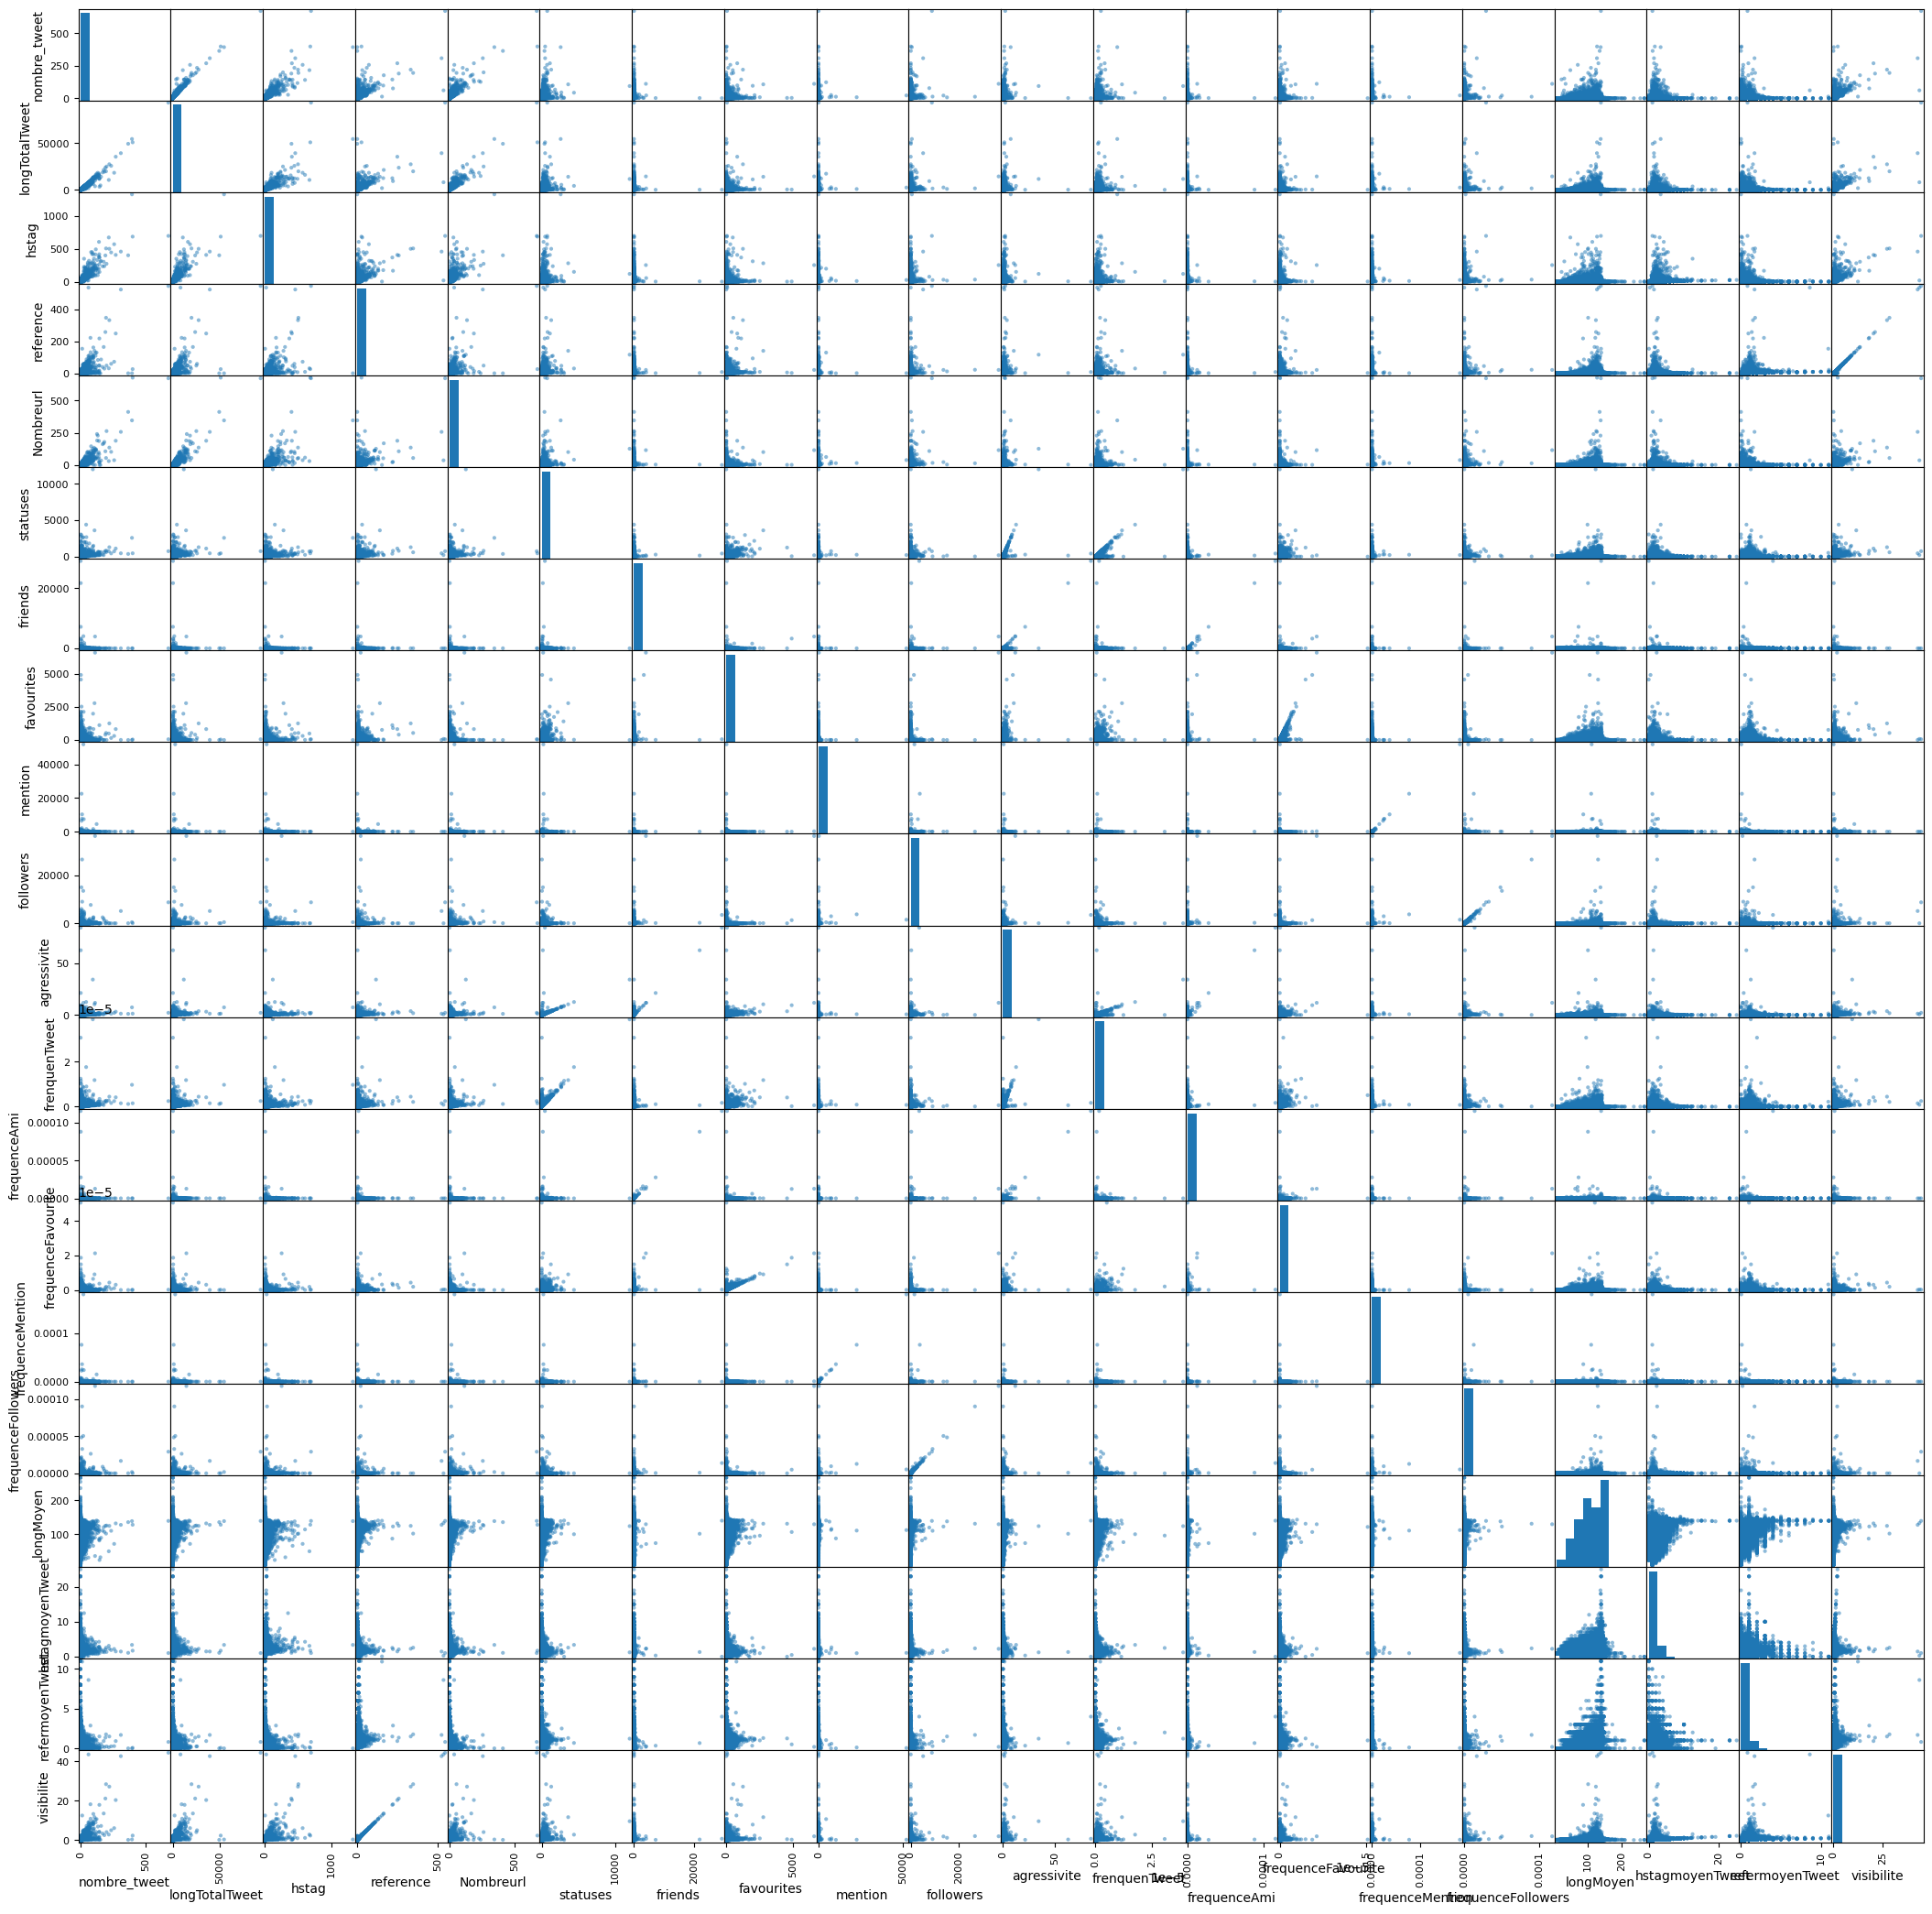

In [37]:
from pandas.plotting import scatter_matrix
scatt_mat = scatter_matrix(X.iloc[1:60000,1:21],figsize=(26,26))[-1]

## Variables a retenir apres la visualisation de la matrice de correlation
### Les correlations observees
- longTotalTweet et nombre_tweet
- statuses et frequenceTweet
- friends et frequenceAmi
- favourite et frequencefavourite
- mention et frequenceMention
- followers et frequenceFollowers
- visibilite et reference
### Attributs a laisse
- longTotaltweet
- statuses
- friends
- favourite
- mention
- followers
- reference

In [21]:
X.drop(X.columns[[2,4,6,7,8,9,10]], inplace = True, axis =1)

C:\Users\thiba\AppData\Local\Temp\ipykernel_15124\726144114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(X.columns[[2,4,6,7,8,9,10]], inplace = True, axis =1)


In [22]:
X.shape

(1843439, 14)

In [23]:
X.columns

Index(['_id', 'nombre_tweet', 'hstag', 'Nombreurl', 'agressivite',
       'frenquenTweet', 'frequenceAmi', 'frequenceFavourite',
       'frequenceMention', 'frequenceFollowers', 'longMoyen',
       'hstagmoyenTweet', 'refermoyenTweet', 'visibilite'],
      dtype='object')

### Detection des outliers au niveau des donnees

Text(0, 0.5, 'refermoyenTweet')

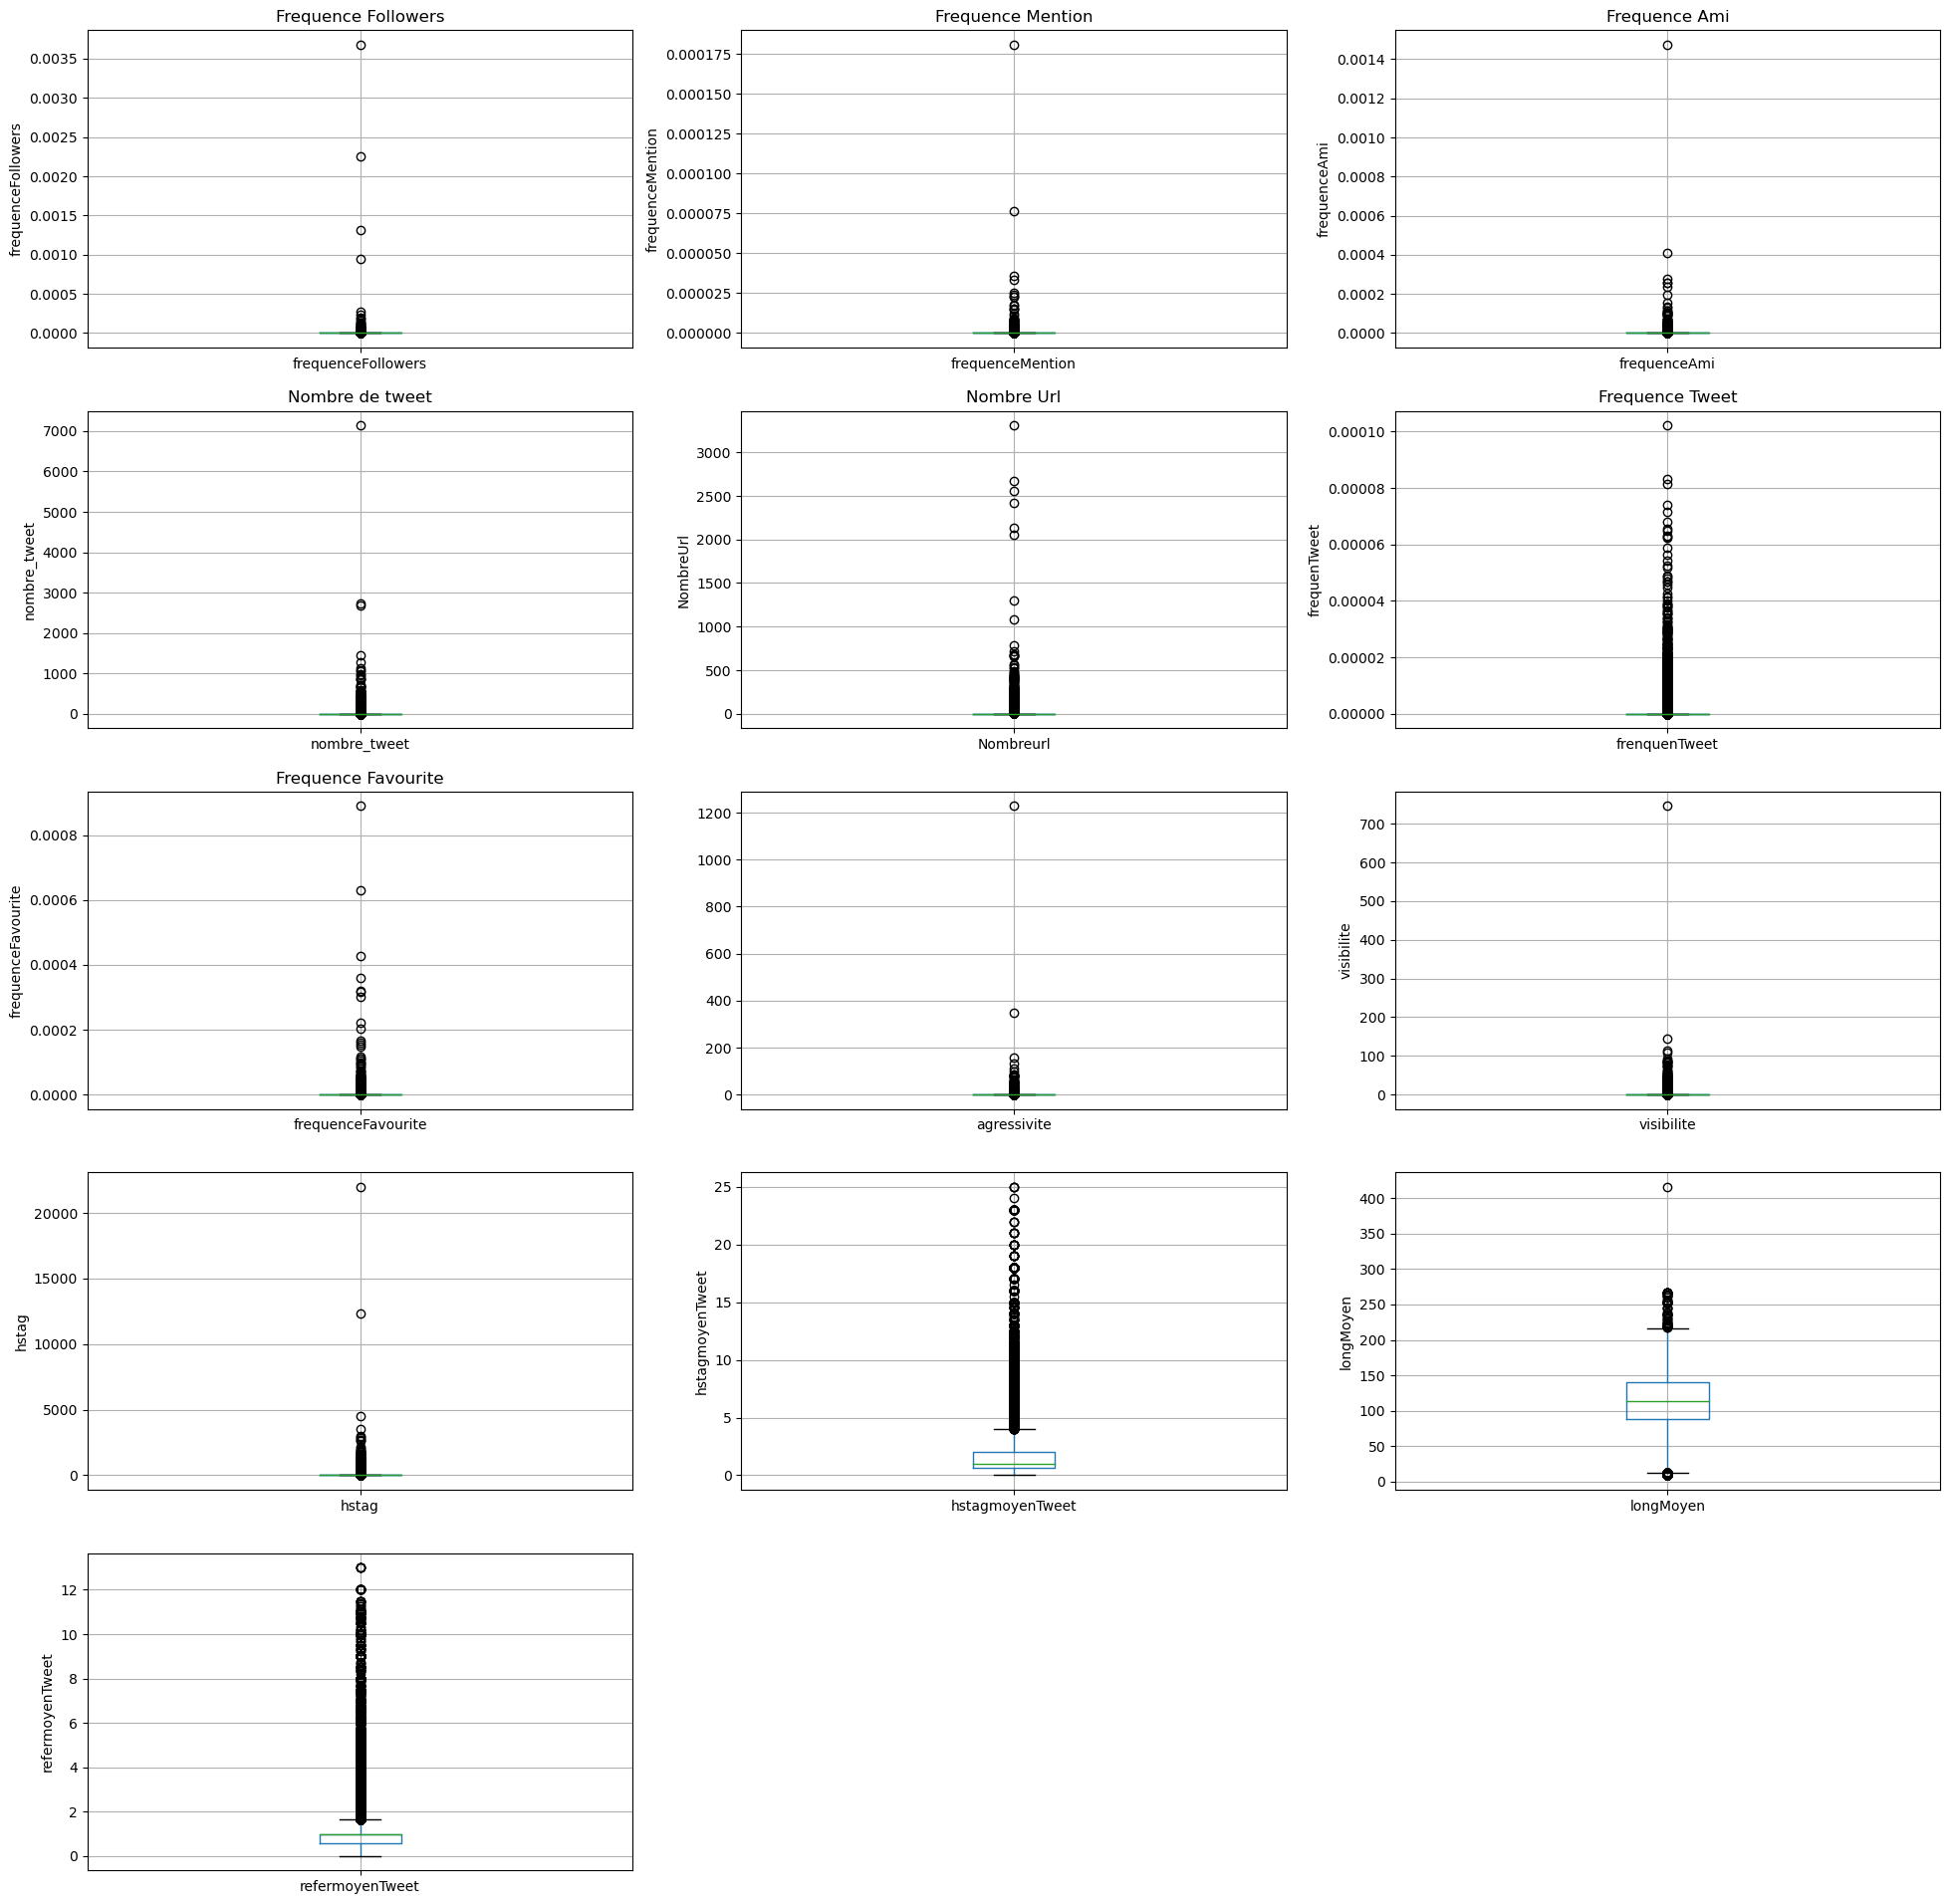

In [56]:
plt.figure(figsize=(24,24))
plt.subplot(5, 3, 1)
fig = X.boxplot(column='frequenceFollowers')
fig.set_title('Frequence Followers')
fig.set_ylabel('frequenceFollowers')



plt.subplot(5, 3, 2)
fig = X.boxplot(column='frequenceMention')
fig.set_title('Frequence Mention')
fig.set_ylabel('frequenceMention')



plt.subplot(5, 3, 3)
fig = X.boxplot(column='frequenceAmi')
fig.set_title('Frequence Ami')
fig.set_ylabel('frequenceAmi')



plt.subplot(5, 3, 4)
fig = X.boxplot(column='nombre_tweet')
fig.set_title('Nombre de tweet')
fig.set_ylabel('nombre_tweet')




plt.subplot(5, 3, 5)
fig = X.boxplot(column='Nombreurl')
fig.set_title('Nombre Url')
fig.set_ylabel('NombreUrl')



plt.subplot(5, 3, 6)
fig = X.boxplot(column='frenquenTweet')
fig.set_title('Frequence Tweet')
fig.set_ylabel('frequenTweet')


plt.subplot(5, 3, 7)
fig = X.boxplot(column='frequenceFavourite')
fig.set_title('Frequence Favourite')
fig.set_ylabel('frequenceFavourite')

plt.subplot(5, 3, 8)
fig = X.boxplot(column='agressivite')
fig.set_title('')
fig.set_ylabel('')

plt.subplot(5, 3, 9)
fig = X.boxplot(column='visibilite')
fig.set_title('')
fig.set_ylabel('visibilite')

plt.subplot(5, 3, 10)
fig = X.boxplot(column='hstag')
fig.set_title('')
fig.set_ylabel('hstag')

plt.subplot(5, 3, 11)
fig = X.boxplot(column='hstagmoyenTweet')
fig.set_title('')
fig.set_ylabel('hstagmoyenTweet')

plt.subplot(5, 3, 12)
fig = X.boxplot(column='longMoyen')
fig.set_title('')
fig.set_ylabel('longMoyen')

plt.subplot(5, 3, 13)
fig = X.boxplot(column='refermoyenTweet')
fig.set_title('')
fig.set_ylabel('refermoyenTweet')

In [57]:
X[X['frequenceFollowers']>0.0005]

,_id,nombre_tweet,hstag,Nombreurl,agressivite,frenquenTweet,frequenceAmi,frequenceFavourite,frequenceMention,frequenceFollowers,longMoyen,hstagmoyenTweet,refermoyenTweet,visibilite
141036,68596545,6,9.0,7.0,0.457143,3.339010e-08,5.602116e-07,2.756538e-06,9.312127e-07,0.002257,125.333333,1.500000,0.333333,0.287143
246415,138372303,205,400.0,195.0,1.391429,1.569151e-06,0.000000e+00,1.611038e-07,2.625991e-06,0.000951,117.331707,1.951220,0.600000,10.177387
448876,294150384,50,171.0,100.0,1.165714,3.730809e-07,1.164465e-06,4.522193e-07,2.449521e-06,0.003679,138.760000,3.420000,0.000000,0.283371
676474,538031518,46,38.0,40.0,2.220000,2.826370e-07,2.645483e-06,0.000000e+00,2.788685e-07,0.001314,133.304348,0.826087,0.652174,2.511304


In [58]:
X[X['frequenceMention']>0.00005]

,_id,nombre_tweet,hstag,Nombreurl,agressivite,frenquenTweet,frequenceAmi,frequenceFavourite,frequenceMention,frequenceFollowers,longMoyen,hstagmoyenTweet,refermoyenTweet,visibilite
1375,4970411,23,25.0,38.0,0.628571,7.661127e-07,0.000000e+00,7.312894e-08,0.000181,0.000005,112.217391,1.086957,0.043478,0.171491
3749,9695312,9,9.0,15.0,0.751429,8.873565e-07,3.386857e-09,1.016057e-08,0.000076,0.000013,110.777778,1.000000,0.111111,0.164286


In [59]:
X[X['frequenceAmi']>0.0004]

,_id,nombre_tweet,hstag,Nombreurl,agressivite,frenquenTweet,frequenceAmi,frequenceFavourite,frequenceMention,frequenceFollowers,longMoyen,hstagmoyenTweet,refermoyenTweet,visibilite
191164,99943864,2674,21993.0,2672.0,1228.597143,1.200155e-05,0.001474,0.000005,1.728334e-08,4.493667e-07,135.409499,8.224757,0.124533,27.797194
1382640,712580241034711040,3,1.0,3.0,346.637143,3.383305e-08,0.000410,0.000000,4.736627e-08,2.469812e-07,139.333333,0.333333,0.000000,0.027619


In [60]:
X[X['Nombreurl']>1000]

,_id,nombre_tweet,hstag,Nombreurl,agressivite,frenquenTweet,frequenceAmi,frequenceFavourite,frequenceMention,frequenceFollowers,longMoyen,hstagmoyenTweet,refermoyenTweet,visibilite
191164,99943864,2674,21993.0,2672.0,1228.597143,1.200155e-05,1.474396e-03,4.742547e-06,1.728334e-08,4.493667e-07,135.409499,8.224757,0.124533,27.797194
881369,1254086161,2731,1599.0,2422.0,18.005714,2.089952e-05,4.320142e-08,1.127225e-05,0.000000e+00,5.317098e-08,135.976932,0.585500,0.328817,73.171370
1652342,926428251924369409,571,1126.0,1082.0,1.957143,6.405266e-06,1.212108e-06,0.000000e+00,0.000000e+00,2.224051e-08,138.584939,1.971979,0.798599,37.294821
1680206,944593415794069504,7143,12370.0,3310.0,20.088571,2.334864e-05,0.000000e+00,0.000000e+00,3.320814e-09,2.291362e-07,106.492930,1.731765,1.281394,745.459203
1755998,985161847551811585,968,69.0,1300.0,3.751429,4.595231e-06,0.000000e+00,3.499795e-09,0.000000e+00,0.000000e+00,143.614669,0.071281,1.086777,85.668763
1777739,994580098748567552,1438,1755.0,2049.0,9.377143,4.229671e-07,1.009353e-05,0.000000e+00,3.204296e-09,2.316706e-06,103.232267,1.220445,0.000000,0.101123
1800916,1001242131938271232,1068,3545.0,2135.0,3.351429,3.761333e-06,5.861817e-08,0.000000e+00,0.000000e+00,0.000000e+00,136.092697,3.319288,0.000000,0.275027
1824651,1006593868127539201,1286,2125.0,2559.0,3.814286,4.613343e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,133.827372,1.652411,0.010886,1.276914


In [61]:
X[X['frenquenTweet']>0.0001]

,_id,nombre_tweet,hstag,Nombreurl,agressivite,frenquenTweet,frequenceAmi,frequenceFavourite,frequenceMention,frequenceFollowers,longMoyen,hstagmoyenTweet,refermoyenTweet,visibilite
467707,309096139,5,1.0,4.0,78.934286,0.000102,1.110116e-08,4.070426e-08,7.400774e-09,3.330348e-08,53.6,0.2,0.2,0.098


In [62]:
X[X['frequenceFavourite']>0.0003]

,_id,nombre_tweet,hstag,Nombreurl,agressivite,frenquenTweet,frequenceAmi,frequenceFavourite,frequenceMention,frequenceFollowers,longMoyen,hstagmoyenTweet,refermoyenTweet,visibilite
703590,574092325,8,12.0,0.0,2.160000,9.742015e-07,3.516630e-06,0.000629,8.138146e-07,2.472927e-05,81.500000,1.500000,0.250000,0.287143
751472,709078219,3,1.0,3.0,1.360000,5.456437e-07,1.322892e-06,0.000316,1.609453e-07,4.875464e-06,101.666667,0.333333,1.000000,0.271905
923531,1469716248,74,138.0,30.0,0.708571,8.243022e-07,8.831809e-08,0.000359,3.679921e-09,2.380909e-06,93.283784,1.864865,0.851351,5.284517
1000544,2177312433,2,1.0,0.0,0.137143,2.692900e-07,5.729575e-09,0.000427,5.729575e-09,1.718873e-08,115.500000,0.500000,1.000000,0.204286
1045234,2337799071,8,7.0,5.0,53.020000,4.764668e-07,1.128799e-04,0.000319,6.719404e-07,1.970129e-04,106.750000,0.875000,0.250000,0.235357
1141715,2780981828,2,2.0,2.0,0.882857,2.333606e-07,2.341940e-06,0.000890,1.416832e-07,2.867001e-06,110.500000,1.000000,1.000000,0.245714
1500659,812167633655230465,62,78.0,14.0,5.857143,3.140777e-06,4.337263e-06,0.000301,2.188695e-08,1.710830e-06,72.338710,1.258065,0.403226,2.139954


In [63]:
X[X['visibilite']>200]

,_id,nombre_tweet,hstag,Nombreurl,agressivite,frenquenTweet,frequenceAmi,frequenceFavourite,frequenceMention,frequenceFollowers,longMoyen,hstagmoyenTweet,refermoyenTweet,visibilite
1680206,944593415794069504,7143,12370.0,3310.0,20.088571,0.000023,0.0,0.0,3.320814e-09,2.291362e-07,106.49293,1.731765,1.281394,745.459203


In [64]:
X[X['hstag']>5000]

,_id,nombre_tweet,hstag,Nombreurl,agressivite,frenquenTweet,frequenceAmi,frequenceFavourite,frequenceMention,frequenceFollowers,longMoyen,hstagmoyenTweet,refermoyenTweet,visibilite
191164,99943864,2674,21993.0,2672.0,1228.597143,0.000012,0.001474,0.000005,1.728334e-08,4.493667e-07,135.409499,8.224757,0.124533,27.797194
1680206,944593415794069504,7143,12370.0,3310.0,20.088571,0.000023,0.000000,0.000000,3.320814e-09,2.291362e-07,106.492930,1.731765,1.281394,745.459203


In [67]:
X[X['agressivite']>200]

,_id,nombre_tweet,hstag,Nombreurl,agressivite,frenquenTweet,frequenceAmi,frequenceFavourite,frequenceMention,frequenceFollowers,longMoyen,hstagmoyenTweet,refermoyenTweet,visibilite
191164,99943864,2674,21993.0,2672.0,1228.597143,1.200155e-05,0.001474,0.000005,1.728334e-08,4.493667e-07,135.409499,8.224757,0.124533,27.797194
1382640,712580241034711040,3,1.0,3.0,346.637143,3.383305e-08,0.000410,0.000000,4.736627e-08,2.469812e-07,139.333333,0.333333,0.000000,0.027619


## Documentation sur les outliers
Nous allons faire sortir les outliers et les documenter
- 141036
- 246415
- 448876
- 676474
- 1375
- 3739
- 191164
- 1382640
- 881369
- 1652342
- 1680206
- 1755998
- 1777739
- 1800916
- 1824651
- 467707
- 703590
- 751472
- 923531
- 1000544
- 1045234
- 1141715
- 1500659
- 1382640

In [24]:
X.drop([141036,246415,448876,676474,1375
,3739
,191164
,1382640
,881369
,1652342
,1680206
,1755998
,1777739
,1800916
,1824651
,467707
,703590
,751472
,923531
,1000544
,1045234
,1141715
,1500659
,1382640]
, inplace = True)
print('fin')

fin


C:\Users\thiba\AppData\Local\Temp\ipykernel_15124\1257097737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop([141036,246415,448876,676474,1375


In [25]:
X.to_csv('kmeans1.csv', sep=',')
print('fin')

fin


In [26]:
X.head(5)

,_id,nombre_tweet,hstag,Nombreurl,agressivite,frenquenTweet,frequenceAmi,frequenceFavourite,frequenceMention,frequenceFollowers,longMoyen,hstagmoyenTweet,refermoyenTweet,visibilite
0,418,6,6.0,5.0,0.165714,2.816108e-07,1.536059e-08,1.945675e-07,1.024039e-08,7.168275e-08,113.333333,1.0,0.666667,0.408571
1,730,1,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,139.000000,0.0,1.000000,0.081429
2,761,1,0.0,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,31.000000,0.0,0.000000,0.000000
3,885,1,1.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,88.000000,1.0,0.000000,0.082857
4,922,1,3.0,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,140.000000,3.0,1.000000,0.330000


### Creer la base de donnees Mongodb des Users

In [121]:
##Transformer la dataframe en dictionnaire
start = time.time()
df_dict = df.to_dict('records')
print('-------------------------------Temps execution')
print(time.time() - start)

-------------------------------Temps execution
55.30426502227783


In [125]:
##Inserer le dictionnaire 
user = db['utilisateur']
start = time.time()
user.insert_many(df_dict)
print('-----------------------------Temps execution')
print(time.time() - start)

-----------------------------Temps execution
276.8498225212097


In [39]:
df.head(5)

,_id,first_tweet,last_tweet,MaxAmi,MinAmi,MaxStatuses,MinStatuses,Maxfavourites,Minfavourites,Maxmention,...,tweets,longTotalTweet,hstag,Nombreurl,T1,T2,statuses,friends,favourites,mention
0,418,Sat Jun 16 04:01:01 +0000 2018,Fri Jun 15 10:46:07 +0000 2018,2489,2486,66656,66601,13523,13485,4537,...,['Re: 4SQ. You can search for “world cup” or ...,680.0,10.0,5.0,1.529114e+09,1.529114e+09,55,3,38,2
1,730,Thu Jun 14 18:06:49 +0000 2018,Thu Jun 14 18:06:49 +0000 2018,191,191,12159,12159,3164,3164,20,...,"[""RT @Kasparov63: As I've written, it is up to...",139.0,1.0,0.0,1.528992e+09,1.528992e+09,0,0,0,0
2,761,Fri Jun 15 21:05:55 +0000 2018,Fri Jun 15 21:05:55 +0000 2018,483,483,29724,29724,46254,46254,188,...,['Co-sign https://t.co/3fJRCqqaBl'],31.0,0.0,1.0,1.529090e+09,1.529090e+09,0,0,0,0
3,885,Fri Jun 15 22:48:44 +0000 2018,Fri Jun 15 22:48:44 +0000 2018,1099,1099,13879,13879,6091,6091,1883,...,"['If you tape a #WorldCup game to work, that a...",88.0,1.0,0.0,1.529096e+09,1.529096e+09,0,0,0,0
4,922,Sun Jun 17 02:07:11 +0000 2018,Sun Jun 17 02:07:11 +0000 2018,934,934,11717,11717,12046,12046,268,...,['If you’re in SF tomorrow swing by our #GER\u...,140.0,4.0,1.0,1.529194e+09,1.529194e+09,0,0,0,0
